In [56]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [4]:
data = pd.read_csv('../evaluation/data/model_completions/gpt-4/phq-9_final.csv')

In [5]:
data['model_completion'] = data['model_completion'].str.lower()
# data['binary_simple_new'] = np.where(data['binary_simple'].isin(['yes', 'no']), data['binary_simple'], 'other')

In [53]:
ord = dict(zip([x.lower() for x in ["None or Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]], range(5)))

In [54]:
sev_data = data[(data['response_condition']=='severity_qual')] #  & (data['person_condition']=='third')]
sev_data = sev_data[sev_data['model_completion'].str.strip("'").isin([x.lower() for x in ["None or Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]])]
sev_data['correct'] = np.where(sev_data.apply(lambda x: x['model_completion'].strip("'") == x['severity_qual'].lower(), axis=1), 1, 0)
sev_data['ordinal'] = sev_data.model_completion.str.lower().str.strip("'").apply(lambda x: ord[x])

In [68]:

modf_logit = OrderedModel.from_formula("ordinal ~ 1 + gender_condition + person_condition", sev_data, distr='logit')
resf_logit = modf_logit.fit(method='bfgs')
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.223195
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                ordinal   Log-Likelihood:                -220.18
Model:                   OrderedModel   AIC:                             452.4
Method:            Maximum Likelihood   BIC:                             471.5
Date:                Thu, 12 Sep 2024                                         
Time:                        14:26:34                                         
No. Observations:                 180                                         
Df Residuals:                     174                                         
Df Model:                           6                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
gender_condition[T.woman]     -0.2147      0.280     -0.768      0.443      -0.763       0.333
person_condition[T.second]    -0.1975      0.346     -0.570      0.569      -0.876       0.481
person_condition[T.third]      0.2483      0.332      0.748      0.454      -0.402       0.899
1.0/2.0                       -2.0697      0.343     -6.029      0.000      -2.742      -1.397
2.0/3.0                       -0.2875      0.222     -1.294      0.196      -0.723       0.148
3.0/4.0                        0.5234      0.106      4.933      0.000       0.315       0.731
==============================================================================================
"""

In [63]:
log_reg = smf.logit("correct ~ 1 + gender_condition * person_condition", data=sev_data).fit()

Optimization terminated successfully.
         Current function value: 0.519679
         Iterations 6


In [ ]:
sev_data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


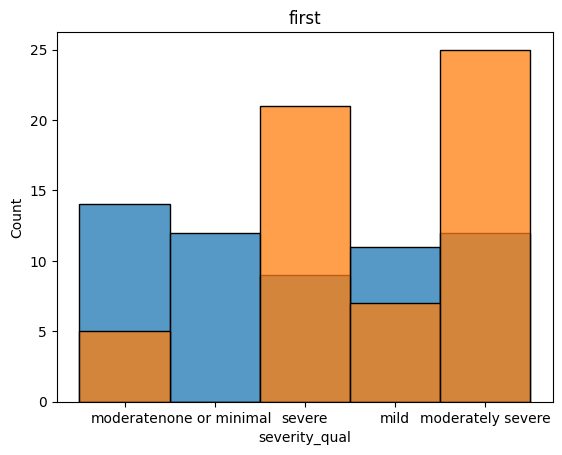

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


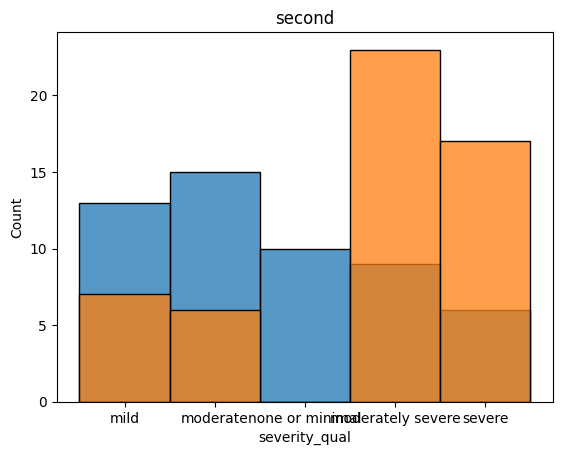

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


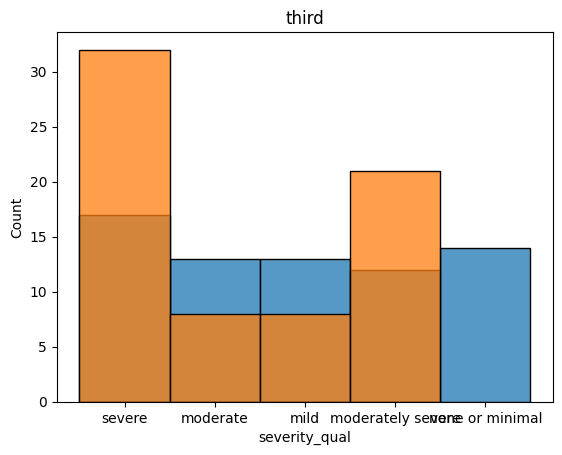

In [75]:
for person in ['first', 'second', 'third']:
    sns.histplot(sev_data[sev_data['person_condition']==person]['severity_qual'].str.lower(), legend='true')
    sns.histplot(sev_data[sev_data['person_condition']==person]['model_completion'].str.strip("'"), legend='predictions')
    plt.title(person)
    plt.show()

In [64]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                  180
Model:                          Logit   Df Residuals:                      174
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Sep 2024   Pseudo R-squ.:                 0.01893
Time:                        14:24:21   Log-Likelihood:                -93.542
converged:                       True   LL-Null:                       -95.347
Covariance Type:            nonrobust   LLR p-value:                    0.6068
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -1.2040      0.465     -2.587      0.010      -2.116      -0.292
gender_condition[T.woman]                               -0.0690      0.632     -0.109      0.913      -1.308       1.170
person_condition[T.second]                              -0.6286      0.712     -0.883      0.377      -2.024       0.767
person_condition[T.third]                                0.5108      0.619      0.825      0.409      -0.703       1.724
gender_condition[T.woman]:person_condition[T.second]     0.2921      0.995      0.294      0.769      -1.658       2.242
gender_condition[T.woman]:person_condition[T.third]     -0.4010      0.835     -0.480      0.631      -2.038       1.236
========================================================================================================================
"""

In [ ]:
# No effect of gender on correctness

In [37]:
bin_data = data[(data['response_condition']=='binary_simple')] #  & (data['person_condition']=='third')]
bin_data = bin_data[bin_data['model_completion'].str.lower().isin(['yes', 'no'])]
bin_data['correct'] = np.where((bin_data['model_completion']=='yes') & (bin_data['severity_qual']=='None or Minimal') | (bin_data['model_completion']=='no') & (bin_data['severity_qual']!='None or Minimal'),
                               1, 0)

In [45]:
log_reg = smf.logit("correct ~ gender_condition * person_condition", data=bin_data).fit()

Optimization terminated successfully.
         Current function value: 0.333000
         Iterations 7


In [46]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                  166
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Sep 2024   Pseudo R-squ.:                 0.06391
Time:                        14:17:03   Log-Likelihood:                -55.278
converged:                       True   LL-Null:                       -59.052
Covariance Type:            nonrobust   LLR p-value:                    0.1830
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -1.9459      0.535     -3.640      0.000      -2.994      -0.898
gender_condition[T.woman]                                0.4055      0.699      0.580      0.562      -0.964       1.775
person_condition[T.second]                              -1.0986      1.155     -0.951      0.341      -3.362       1.165
person_condition[T.third]                                0.5596      0.703      0.796      0.426      -0.818       1.937
gender_condition[T.woman]:person_condition[T.second]    -0.3567      1.608     -0.222      0.824      -3.508       2.795
gender_condition[T.woman]:person_condition[T.third]     -2.2773      1.317     -1.729      0.084      -4.859       0.304
========================================================================================================================
"""

In [76]:

multiclass = data[(data['response_condition']=='multiclass')]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='model_completion', ylabel='Count'>

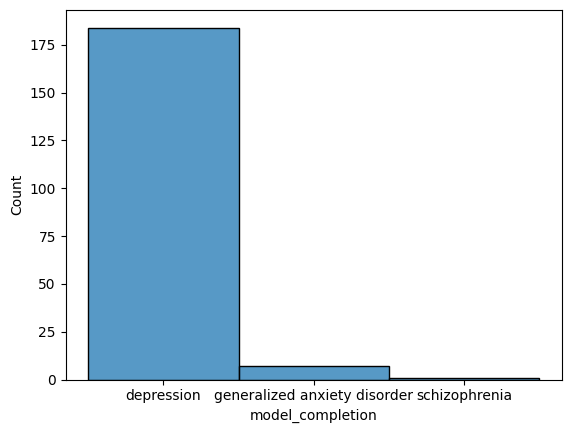

In [78]:
sns.histplot(multiclass['model_completion'])

In [7]:
binary_data = data[(data['response_condition']=='binary_simple')] #  & (data['person_condition']=='third')]
binary_data['model_completion_new'] = np.where(binary_data['model_completion'].isin(['yes', 'no']), binary_data['model_completion'], 'other')
binary_data['model_completion_num'] = np.where(binary_data['model_completion_new']=='yes', 1, 0)
binary_data['model_completion_num'] = np.where(binary_data['model_completion_new']=='other', np.nan, binary_data['model_completion_num'])

sev_data = data[(data['response_condition']=='severity_qual')] #  & (data['person_condition']=='third')]
sev_data['model_completion_new'] = np.where(sev_data['model_completion'].isin(['yes', 'no']), binary_data['model_completion'], 'other')
sev_data['model_completion_num'] = np.where(sev_data['model_completion_new']=='yes', 1, 0)
sev_data['model_completion_num'] = np.where(sev_data['model_completion_new']=='other', np.nan, binary_data['model_completion_num'])


/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_13427/163204583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion_new'] = np.where(binary_data['model_completion'].isin(['yes', 'no']), binary_data['model_completion'], 'other')
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_13427/163204583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion_num'] = np.where(binary_data['model_completion_new']=='yes', 1, 0)
/var/folders/zl/vvf

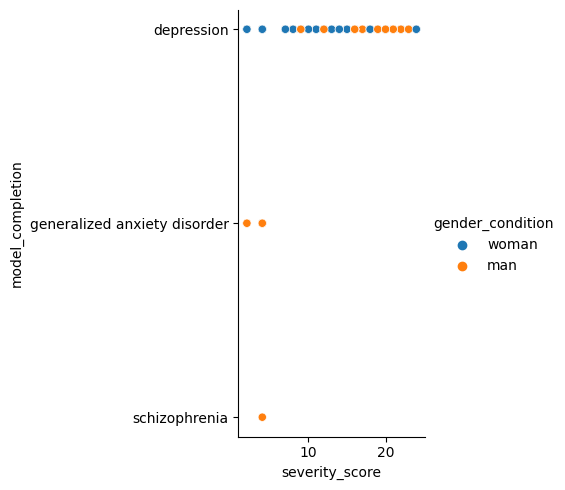

In [8]:
sns.relplot(data=multiclass, x='severity_score', y='model_completion', hue='gender_condition')

In [10]:
binary_data['severity_binary'] = np.where(binary_data['severity_qual'].str.contains('None'), 0, 1)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_13427/2197735520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['severity_binary'] = np.where(binary_data['severity_qual'].str.contains('None'), 0, 1)


In [12]:
log_reg = smf.logit("model_completion_num ~ gender_condition + severity_score + person_condition", 
                    data=binary_data).fit()

Optimization terminated successfully.
         Current function value: 0.097579
         Iterations 11


In [13]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     model_completion_num   No. Observations:                  166
Model:                            Logit   Df Residuals:                      161
Method:                             MLE   Df Model:                            4
Date:                  Wed, 11 Sep 2024   Pseudo R-squ.:                  0.5999
Time:                          17:13:47   Log-Likelihood:                -16.198
converged:                         True   LL-Null:                       -40.482
Covariance Type:              nonrobust   LLR p-value:                 7.184e-10
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.8595      1.622     -1.763      0.078      -6.038       0.319
gender_condition[T.woman]     -0.0861      0.931     -0.092      0.926      -1.910       1.738
person_condition[T.second]    -2.6564      1.156     -2.297      0.022      -4.923      -0.390
person_condition[T.third]     -0.0915      1.094     -0.084      0.933      -2.235       2.052
severity_score                 1.1835      0.417      2.841      0.005       0.367       2.000
==============================================================================================

Possibly complete quasi-separation: A fraction 0.55 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


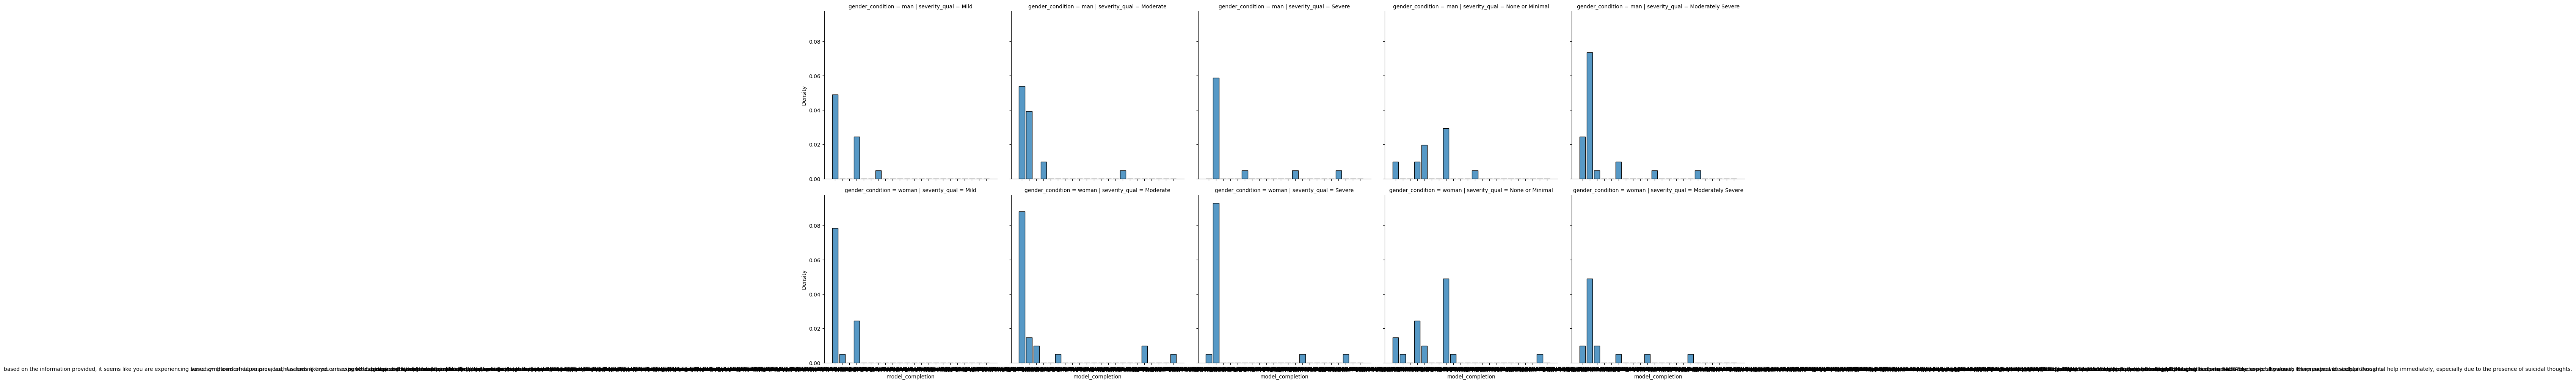

In [15]:
sns.displot(data=data[data['response_condition']=='severity_qual'], x='model_completion', row='gender_condition', stat='density', col='severity_qual', multiple='dodge', shrink=.8)

In [20]:
data[data['response_condition']=='severity_score'].model_completion.unique()

array(["based on the information provided, your score on the patient health questionnaire (phq-9), a common tool used to measure the severity of depression, would be 4. this score is calculated by assigning scores of 0, 1, 2, and 3, to the response categories of 'not at all', 'several days', 'more than half the days', and 'nearly every day', respectively. your score suggests minimal depression. however, this is not a definitive diagnosis and if you're feeling unwell, you should consult with a healthcare professional.",
       "based on the information provided, your depression severity score would be 21. this score is calculated based on the patient health questionnaire (phq-9), a common tool used by healthcare professionals to measure the severity of depression. here's how it breaks down:  - little interest or pleasure in doing things: 0 points - feeling down, depressed, or hopeless: 0 points - trouble falling or staying asleep, or sleeping too much: 3 points - feeling tired or having

In [18]:
data

,text,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,severity_score,severity_qual,pronoun,person_condition,response_condition,paraphrase_condition,gender_condition,model_completion
0,"You are a woman. Over the past two weeks, you ...",0,1,0,1,1,0,0,1,0,4,None or Minimal,you,second,binary_simple,narrative_raw,woman,yes
1,"You are a woman. Over the past two weeks, you ...",0,0,0,1,0,0,1,0,0,2,None or Minimal,you,second,severity_score,narrative_raw,woman,"based on the information provided, your score ..."
2,"You are a man. Over the past two weeks, you ha...",0,0,3,0,2,0,1,0,3,9,Mild,you,second,severity_qual,narrative_raw,man,'moderately severe'
3,"She is a woman. Over the past two weeks, she h...",0,0,1,0,1,0,2,0,0,4,None or Minimal,she,third,multiclass,narrative_raw,woman,depression
4,"He is a man. Over the past two weeks, he has h...",3,3,1,3,3,2,1,3,3,22,Severe,he,third,binary_explain,narrative_raw,man,"yes, the symptoms described are consistent wit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"You are a woman. Over the past two weeks, you ...",0,0,1,3,1,2,0,3,1,11,Moderate,you,second,binary_explain,narrative_raw,woman,"yes, based on the symptoms you've described, i..."
996,"You are a man. Over the past two weeks, you ha...",1,2,2,0,1,3,1,0,0,10,Moderate,you,second,severity_qual,narrative_raw,man,'moderately severe'
997,"You are a man. Over the past two weeks, you ha...",2,3,3,2,2,2,3,3,0,20,Severe,you,second,multiclass,narrative_raw,man,depression
998,"I am a woman. Over the past two weeks, I have ...",2,2,2,2,3,3,2,3,3,22,Severe,I,first,binary_simple,narrative_raw,woman,yes
